In [2]:
import numpy as np
import pandas as pd

import random
import scipy.stats as st

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import matplotlib as mpl
sns.reset_orig()
sns.set_style('white')
mpl.rcParams['pdf.fonttype'] = 42

### Define feature sets

In [3]:
prot_feat_arr = ['Degree','Betweenness','Closeness','Eigenvector',
                 'ClusteringCoeff','Load', 'Pagerank']
print('# Protein-level features (Prot): %s' % len(prot_feat_arr))

res_feat_arr = ['3DLoc_Annot', 'Percent_Degree_Change',
                'Degree_Change','Betweenness_Change','Closeness_Change','Eigenvector_Change',
                'ClusteringCoeff_Change','Load_Change', 'Pagerank_Change']
print('# Residue-level features (Res): %s' % len(res_feat_arr))

net_feat_arr = ['3DLoc_Annot',
                'Degree','Betweenness','Closeness','Eigenvector',
                'ClusteringCoeff','Load', 'Pagerank',
                'Percent_Degree_Change',
                'Degree_Change','Betweenness_Change','Closeness_Change','Eigenvector_Change',
                'ClusteringCoeff_Change','Load_Change', 'Pagerank_Change']
print('# Network-based features (Net=Prot+Res): %s' % len(net_feat_arr))

aa_feat_arr = ['AABLOSUM', 'AACharge', 'AACOSMIC', 'AACOSMICvsHapMap', 'AACOSMICvsSWISSPROT', 'AAEx', 
               'AAGrantham', 'AAHapMap', 'AAHGMD2003', 'AAHydrophobicity', 'AAMJ', 'AAPAM250', 'AAPolarity', 
               'AATransition', 'AATripletFirstDiffProb', 'AATripletFirstProbMut', 'AATripletFirstProbWild', 
               'AATripletSecondDiffProb', 'AATripletSecondProbMut', 'AATripletSecondProbWild', 
               'AATripletThirdDiffProb', 'AATripletThirdProbMut', 'AATripletThirdProbWild', 'AAVB', 'AAVolume', 
               'ExonConservation', 'ExonHapMapSnpDensity', 'ExonSnpDensity', 'HMMEntropy', 'HMMPHC', 
               'HMMRelEntropy', 'MGAEntropy', 'MGAPHC', 'MGARelEntropy', 'PredBFactorF', 'PredBFactorM', 
               'PredBFactorS', 'PredRSAB', 'PredRSAE', 'PredRSAI', 'PredSSC', 'PredSSE', 'PredSSH', 
               'PredStabilityH', 'PredStabilityL', 'PredStabilityM', 'RegCompC', 'RegCompDE', 'RegCompEntropy', 
               'RegCompG', 'RegCompH', 'RegCompILVM', 'RegCompKR', 'RegCompNormEntropy', 'RegCompP', 'RegCompQ', 
               'RegCompWYF', 'UniprotACTSITE', 'UniprotBINDING', 'UniprotCABIND', 'UniprotCARBOHYD', 
               'UniprotCOMPBIAS', 'UniprotDISULFID', 'UniprotDNABIND', 'UniprotDOM_Chrom', 'UniprotDOM_LOC', 
               'UniprotDOM_MMBRBD', 'UniprotDOM_PostModEnz', 'UniprotDOM_PostModRec', 'UniprotDOM_PPI', 
               'UniprotDOM_RNABD', 'UniprotDOM_TF', 'UniprotLIPID', 'UniprotMETAL', 'UniprotMODRES', 
               'UniprotMOTIF', 'UniprotNPBIND', 'UniprotPROPEP', 'UniprotREGIONS', 'UniprotREP', 'UniprotSECYS', 
               'UniprotSIGNAL', 'UniprotSITE', 'UniprotTRANSMEM', 'UniprotZNFINGER']
# Remove these 2 features from aa_feat_arr because they had NaN values for all mutations
aa_feat_arr.remove('UniprotLIPID')
aa_feat_arr.remove('UniprotSECYS')
print('# Classic amino acid features (AA): %s' % len(aa_feat_arr))

tot_feat_arr = net_feat_arr + aa_feat_arr
print('# All features (Net+AA): %s' % len(tot_feat_arr))

# Protein-level features (Prot): 7
# Residue-level features (Res): 9
# Network-based features (Net=Prot+Res): 16
# Classic amino acid features (AA): 83
# All features (Net+AA): 99


### Define Functions

In [4]:
def get_classifier_performance_CV(df, train_idx, test_idx, feat_arr):
    
    # Create classifier
    clf = RandomForestClassifier(n_estimators=1000, max_features='sqrt', random_state=0, n_jobs=-1)

    # Get feature values (X) and the correct class labels (y)
    X = df[feat_arr].values
    y = [1 if mut=='Driver' else 0 for mut in df['Mut_type'].values]
    
    # Set up a custom iterable for CV splits
    custom_cv = zip(train_idx, test_idx)
    
    # Get prediction scores of test sets of each CV iteration
    y_pred_proba = cross_val_predict(clf, X, y, cv=custom_cv, method='predict_proba')
    
    return y_pred_proba[:,1]

In [5]:
def get_pred_interface(df, y_preds):
    # Extract indices of interface mutations
    inter_idx = df[(df['3DLoc_Annot']>0)&(df['3DLoc_Annot']<1)].index
    y_preds = y_preds[inter_idx]
    
    # Get the correct class labels (y)
    y = [1 if mut=='Driver' else 0 for mut in df['Mut_type'].values]
    y = list(np.array(y)[inter_idx])
    
    # Return class labels and prediction scores of interface mutations only
    return (y, y_preds)

In [20]:
def plot_roc_all_and_interface(y, y_preds_prot, y_preds_res, y_preds_net,
                               y_preds_aa, y_preds_res_aa, y_preds_net_aa,
                               y_int, y_preds_prot_int, y_preds_res_int, y_preds_net_int,
                               y_preds_aa_int, y_preds_res_aa_int, y_preds_net_aa_int,
                               fig_outfile):

    fig = plt.figure(figsize=(6.5, 2.38))

    ax = plt.subplot(1, 3, 1)

    fpr, tpr, threshold = metrics.roc_curve(y, y_preds_prot, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#33a02c', label = 'Prot = %0.3f' % auc, linewidth=1) #lightgreen
    
    fpr, tpr, threshold = metrics.roc_curve(y, y_preds_res, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#ff7f00', label = 'Res = %0.3f' % auc, linewidth=1) #lightpink
    
    fpr, tpr, threshold = metrics.roc_curve(y, y_preds_net, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#1f78b4', label = 'Net = %0.3f' % auc, linewidth=1) #lightblue

    plt.legend(loc = 'lower right')
    plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.xticks((0,0.2,0.4,0.6,0.8,1)); plt.yticks((0,0.2,0.4,0.6,0.8,1))
    plt.title('Network features', fontsize=9)
    
    ax = plt.subplot(1, 3, 2)

    fpr, tpr, threshold = metrics.roc_curve(y, y_preds_net, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#1f78b4', label = 'Net = %0.3f' % auc, linewidth=1) #lightblue

    fpr, tpr, threshold = metrics.roc_curve(y, y_preds_aa, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'gray', label = 'AA = %0.3f' % auc, linewidth=1) #lightgray
    
    fpr, tpr, threshold = metrics.roc_curve(y, y_preds_res_aa, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'mediumorchid', label = 'Res & AA = %0.3f' % auc, linewidth=1) #peachpuff
    
    fpr, tpr, threshold = metrics.roc_curve(y, y_preds_net_aa, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#b15928', label = 'Net & AA = %0.3f' % auc, linewidth=2) #indianred

    plt.legend(loc = 'lower right')
    plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.xticks((0,0.2,0.4,0.6,0.8,1)); plt.yticks((0,0.2,0.4,0.6,0.8,1))
    plt.title('Network and AA features', fontsize=9)
    
    ax = plt.subplot(1, 3, 3)
    
    fpr, tpr, threshold = metrics.roc_curve(y_int, y_preds_prot_int, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#33a02c', label = 'Prot = %0.3f' % auc, linewidth=1) #lightgreen  
    
    fpr, tpr, threshold = metrics.roc_curve(y_int, y_preds_res_int, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#ff7f00', label = 'Res = %0.3f' % auc, linewidth=1) #lightpink
    
    fpr, tpr, threshold = metrics.roc_curve(y_int, y_preds_net_int, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#1f78b4', label = 'Net = %0.3f' % auc, linewidth=1) #lightblue

    fpr, tpr, threshold = metrics.roc_curve(y_int, y_preds_aa_int, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'gray', label = 'AA = %0.3f' % auc, linewidth=1)  #lightgray
    
    fpr, tpr, threshold = metrics.roc_curve(y_int, y_preds_res_aa_int, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'mediumorchid', label = 'Res & AA = %0.3f' % auc, linewidth=1) #peachpuff
    
    fpr, tpr, threshold = metrics.roc_curve(y_int, y_preds_net_aa_int, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#b15928', label = 'Net & AA = %0.3f' % auc, linewidth=2) #indianred

    plt.legend(loc = 'lower right')
    plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.xticks((0,0.2,0.4,0.6,0.8,1)); plt.yticks((0,0.2,0.4,0.6,0.8,1))
    plt.title('Interface residues only', fontsize=9)
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=.34)

    plt.savefig(fig_outfile, transparent=True, dpi=300)
    plt.show()

In [26]:
def plot_prc_all_and_interface(y, y_preds_prot, y_preds_res, y_preds_net,
                               y_preds_aa, y_preds_res_aa, y_preds_net_aa,
                               y_int, y_preds_prot_int, y_preds_res_int, y_preds_net_int,
                               y_preds_aa_int, y_preds_res_aa_int, y_preds_net_aa_int,
                               fig_outfile):

    fig = plt.figure(figsize=(6.5, 2.25))

    ax = plt.subplot(1, 3, 1)

    pre, rec, thresh = metrics.precision_recall_curve(y, y_preds_prot, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#33a02c', label = 'Prot = %0.3f' % auc, linewidth=1) #lightgreen
    
    pre, rec, thresh = metrics.precision_recall_curve(y, y_preds_res, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#ff7f00', label = 'Res = %0.3f' % auc, linewidth=1) #lightpink
    
    pre, rec, thresh = metrics.precision_recall_curve(y, y_preds_net, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#1f78b4', label = 'Net = %0.3f' % auc, linewidth=1) #lightblue

    plt.legend(loc = 'lower left')
    plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.xticks((0,0.2,0.4,0.6,0.8,1)); plt.yticks((0,0.2,0.4,0.6,0.8,1))
    plt.title('Network features', fontsize=9)
    
    ax = plt.subplot(1, 3, 2)

    pre, rec, thresh = metrics.precision_recall_curve(y, y_preds_net, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#1f78b4', label = 'Net = %0.3f' % auc, linewidth=1) #lightblue

    pre, rec, thresh = metrics.precision_recall_curve(y, y_preds_aa, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, 'gray', label = 'AA = %0.3f' % auc, linewidth=1) #lightgray
    
    pre, rec, thresh = metrics.precision_recall_curve(y, y_preds_res_aa, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, 'mediumorchid', label = 'Res & AA = %0.3f' % auc, linewidth=1) #peachpuff
    
    pre, rec, thresh = metrics.precision_recall_curve(y, y_preds_net_aa, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#b15928', label = 'Net & AA = %0.3f' % auc, linewidth=2) #indianred

    plt.legend(loc = 'lower left')
    plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.xticks((0,0.2,0.4,0.6,0.8,1)); plt.yticks((0,0.2,0.4,0.6,0.8,1))
    plt.title('Network and AA features', fontsize=9)
    
    ax = plt.subplot(1, 3, 3)
    
    pre, rec, thresh = metrics.precision_recall_curve(y_int, y_preds_prot_int, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#33a02c', label = 'Prot = %0.3f' % auc, linewidth=1) #lightgreen  
    
    pre, rec, thresh = metrics.precision_recall_curve(y_int, y_preds_res_int, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#ff7f00', label = 'Res = %0.3f' % auc, linewidth=1) #lightpink
    
    pre, rec, thresh = metrics.precision_recall_curve(y_int, y_preds_net_int, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#1f78b4', label = 'Net = %0.3f' % auc, linewidth=1) #lightblue

    pre, rec, thresh = metrics.precision_recall_curve(y_int, y_preds_aa_int, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, 'gray', label = 'AA = %0.3f' % auc, linewidth=1)  #lightgray
    
    pre, rec, thresh = metrics.precision_recall_curve(y_int, y_preds_res_aa_int, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, 'mediumorchid', label = 'Res & AA = %0.3f' % auc, linewidth=1) #peachpuff
    
    pre, rec, thresh = metrics.precision_recall_curve(y_int, y_preds_net_aa_int, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#b15928', label = 'Net & AA = %0.3f' % auc, linewidth=2) #indianred

    plt.legend(loc = 'lower left')
    plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.xticks((0,0.2,0.4,0.6,0.8,1)); plt.yticks((0,0.2,0.4,0.6,0.8,1))
    plt.title('Interface residues only', fontsize=9)
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=.34)

    plt.savefig(fig_outfile, transparent=True, dpi=300)
    plt.show()

### Read training set for cancer using ExtNet
#### 1:4 ratio of Driver vs. Passenger mutations
#### All feature values are normalized

In [8]:
# read normalized features
total_df_norm = pd.read_table('../data/ExtNet_cancer_features_1-4_norm.txt')
print(total_df_norm.shape)
print('# driver mutations: %s' % len(total_df_norm[total_df_norm['Mut_type']=='Driver']))
print('# passenger mutations: %s' % len(total_df_norm[total_df_norm['Mut_type']=='Passenger']))
print('# all mutations: %s' % len(total_df_norm))
total_df_norm.head()

(8062, 106)
# driver mutations: 1513
# passenger mutations: 6549
# all mutations: 8062


,Index,Mut_type,UID,Unip,Accession,Res,AA_Change,3DLoc_Annot,Degree,Betweenness,...,UniprotMODRES,UniprotMOTIF,UniprotNPBIND,UniprotPROPEP,UniprotREGIONS,UniprotREP,UniprotSIGNAL,UniprotSITE,UniprotTRANSMEM,UniprotZNFINGER
0,0,Driver,1,O00255,ENST00000337652,362,D362H,-0.784087,0.074034,-0.182668,...,-0.064085,-0.057398,-0.063888,-0.08974,2.891795,-0.234045,-0.061958,-0.023957,-0.183294,-0.115404
1,1,Driver,2,O00255,ENST00000337652,184,E184K,1.466936,0.074034,-0.182668,...,-0.064085,-0.057398,-0.063888,-0.08974,-0.345803,-0.234045,-0.061958,-0.023957,-0.183294,-0.115404
2,2,Driver,3,O00255,ENST00000337652,160,S160F,0.341424,0.074034,-0.182668,...,-0.064085,-0.057398,-0.063888,-0.08974,-0.345803,-0.234045,-0.061958,-0.023957,-0.183294,-0.115404
3,3,Driver,6,O14497,ENST00000324856,2143,R2143C,1.466936,0.025723,-0.221841,...,-0.064085,-0.057398,-0.063888,-0.08974,-0.345803,-0.234045,-0.061958,-0.023957,-0.183294,-0.115404
4,4,Driver,7,O14497,ENST00000324856,665,G665A,-0.784087,0.025723,-0.221841,...,-0.064085,-0.057398,-0.063888,-0.08974,-0.345803,-0.234045,-0.061958,-0.023957,-0.183294,-0.115404


### Set up 5-fold gene holdout Cross-Validation (CV)

In [10]:
# Set seed=1 for the random.shuffle() function for a reproducible shuffled output 

# Get a list of all proteins
unip_arr = list(np.unique(total_df_norm['Unip'].values))
print(len(unip_arr), unip_arr[:5])

# Get a list of proteins with driver mutations
driver_unip_arr = list(np.unique(total_df_norm[total_df_norm['Mut_type']=='Driver']['Unip'].values))
# Get a list of proteins with passenger mutations
passenger_unip_arr = list(np.unique(total_df_norm[total_df_norm['Mut_type']=='Passenger']['Unip'].values))
print(len(driver_unip_arr), len(passenger_unip_arr))

# Get a list of proteins with both driver and passenger mutations
double_arr = list()
for unip in driver_unip_arr:
    if unip in passenger_unip_arr:
        double_arr.append(unip)
print(len(double_arr), double_arr[:5])

# Get a list of proteins with only passenger mutations
passenger_unip_arr_2 = [unip for unip in passenger_unip_arr if unip not in driver_unip_arr]
print(len(passenger_unip_arr_2), passenger_unip_arr_2[:5])

# Shuffle the list of proteins with driver mutations (they have passenger mutations too)
driver_unip_arr_shuffled = list(driver_unip_arr)
random.seed(1)
random.shuffle(driver_unip_arr_shuffled)

# Shuffle the list of proteins with only passenger mutations
passenger_unip_arr_shuffled = list(passenger_unip_arr_2)
random.seed(1)
random.shuffle(passenger_unip_arr_shuffled)

3236 ['A0AVI4', 'A0AVK6', 'A0AVT1', 'A0JNW5', 'A0MZ66']
52 3222
38 ['O00255', 'O14497', 'O15169', 'O15550', 'O75376']
3184 ['A0AVI4', 'A0AVK6', 'A0AVT1', 'A0JNW5', 'A0MZ66']


In [11]:
# Split the list of driver and passenger proteins into 5 folds for 5-fold CV
driver_unip_arr_split = np.array_split(np.array(driver_unip_arr_shuffled),5)
passenger_unip_arr_split = np.array_split(np.array(passenger_unip_arr_shuffled),5)

# Get indices of training and test sets for each CV iteration
train_idx, test_idx = list(), list()
for i in np.arange(0,5):
    # Arrange 1 fold to be the test set
    unip_arr_test = list(driver_unip_arr_split[i])+list(passenger_unip_arr_split[i])
    # Arrange remaining 4 folds to be the training set
    unip_arr_train = list()
    for unip in unip_arr:
        if unip not in unip_arr_test:
            unip_arr_train.append(unip)
    train_df_norm = total_df_norm[total_df_norm['Unip'].isin(unip_arr_train)].copy()
    test_df_norm = total_df_norm[total_df_norm['Unip'].isin(unip_arr_test)].copy()
    train_idx.append(list(train_df_norm.index))
    test_idx.append(list(test_df_norm.index))

### Get 5-fold CV results for each feature set

In [12]:
y = [1 if mut=='Driver' else 0 for mut in total_df_norm['Mut_type'].values]

In [13]:
y_preds_prot = get_classifier_performance_CV(total_df_norm, train_idx, test_idx, prot_feat_arr)
y_preds_res = get_classifier_performance_CV(total_df_norm, train_idx, test_idx, res_feat_arr)
y_preds_net = get_classifier_performance_CV(total_df_norm, train_idx, test_idx, net_feat_arr)
y_preds_aa = get_classifier_performance_CV(total_df_norm, train_idx, test_idx, aa_feat_arr)
y_preds_res_aa = get_classifier_performance_CV(total_df_norm, train_idx, test_idx, aa_feat_arr+res_feat_arr)
y_preds_net_aa = get_classifier_performance_CV(total_df_norm, train_idx, test_idx, tot_feat_arr)

In [14]:
y_int, y_preds_prot_int = get_pred_interface(total_df_norm, y_preds_prot)
y_int, y_preds_res_int = get_pred_interface(total_df_norm, y_preds_res)
y_int, y_preds_net_int = get_pred_interface(total_df_norm, y_preds_net)
y_int, y_preds_aa_int = get_pred_interface(total_df_norm, y_preds_aa)
y_int, y_preds_res_aa_int = get_pred_interface(total_df_norm, y_preds_res_aa)
y_int, y_preds_net_aa_int = get_pred_interface(total_df_norm, y_preds_net_aa)

In [15]:
mpl.rc('figure', titlesize=10)
mpl.rc('xtick', labelsize=7)
mpl.rc('ytick', labelsize=7)
mpl.rc('legend', fontsize=6)
mpl.rc('axes', labelsize=8)

### Figure 5d-f

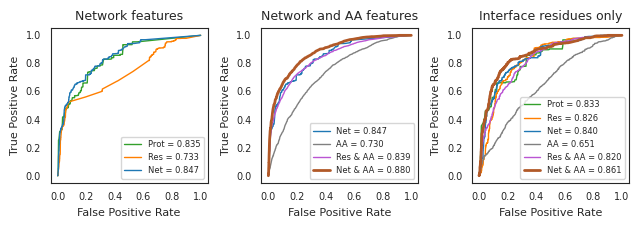

In [22]:
plot_roc_all_and_interface(y, y_preds_prot, y_preds_res, y_preds_net,
                           y_preds_aa, y_preds_res_aa, y_preds_net_aa,
                           y_int, y_preds_prot_int, y_preds_res_int, y_preds_net_int,
                           y_preds_aa_int, y_preds_res_aa_int, y_preds_net_aa_int,
                           '../out/figures/Fig5d-f.pdf')

### Figure S3d-f

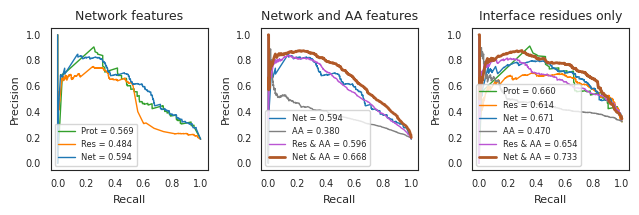

In [27]:
plot_prc_all_and_interface(y, y_preds_prot, y_preds_res, y_preds_net,
                           y_preds_aa, y_preds_res_aa, y_preds_net_aa,
                           y_int, y_preds_prot_int, y_preds_res_int, y_preds_net_int,
                           y_preds_aa_int, y_preds_res_aa_int, y_preds_net_aa_int,
                           '../out/figures/FigS3d-f.pdf')

### Get all predictions made during 5-fold CV using Network & AA features

In [29]:
pred_df = total_df_norm.copy()
pred_df['Pred_Score'] = y_preds_net_aa
print(pred_df.shape)
pred_df.head()

(8062, 107)


,Index,Mut_type,UID,Unip,Accession,Res,AA_Change,3DLoc_Annot,Degree,Betweenness,...,UniprotMOTIF,UniprotNPBIND,UniprotPROPEP,UniprotREGIONS,UniprotREP,UniprotSIGNAL,UniprotSITE,UniprotTRANSMEM,UniprotZNFINGER,Pred_Score
0,0,Driver,1,O00255,ENST00000337652,362,D362H,-0.784087,0.074034,-0.182668,...,-0.057398,-0.063888,-0.08974,2.891795,-0.234045,-0.061958,-0.023957,-0.183294,-0.115404,0.035
1,1,Driver,2,O00255,ENST00000337652,184,E184K,1.466936,0.074034,-0.182668,...,-0.057398,-0.063888,-0.08974,-0.345803,-0.234045,-0.061958,-0.023957,-0.183294,-0.115404,0.076
2,2,Driver,3,O00255,ENST00000337652,160,S160F,0.341424,0.074034,-0.182668,...,-0.057398,-0.063888,-0.08974,-0.345803,-0.234045,-0.061958,-0.023957,-0.183294,-0.115404,0.056
3,3,Driver,6,O14497,ENST00000324856,2143,R2143C,1.466936,0.025723,-0.221841,...,-0.057398,-0.063888,-0.08974,-0.345803,-0.234045,-0.061958,-0.023957,-0.183294,-0.115404,0.117
4,4,Driver,7,O14497,ENST00000324856,665,G665A,-0.784087,0.025723,-0.221841,...,-0.057398,-0.063888,-0.08974,-0.345803,-0.234045,-0.061958,-0.023957,-0.183294,-0.115404,0.069


In [54]:
# Filter for interface muts only
pred_df = pred_df.copy()
pred_df = pred_df[(pred_df['3DLoc_Annot']<1)&(pred_df['3DLoc_Annot']>0)].copy()
print(len(pred_df))

1632


In [55]:
# Extract cases where a protein contains both correctly classified interface driver and passenger mutations
d_unips = np.unique(pred_df[(pred_df['Mut_type']=='Driver')&(pred_df['Pred_Score']>=0.5)]['Unip'].values)
d_unips_filt = list()
for unip in d_unips:
    temp_df = pred_df[pred_df['Unip']==unip].copy()
    if len(temp_df[(temp_df['Mut_type']=='Driver')&(temp_df['Pred_Score']>=0.5)])>0 and len(temp_df[(temp_df['Mut_type']=='Passenger')&(temp_df['Pred_Score']<0.5)])>0:
        d_unips_filt.append(unip)
print(len(d_unips_filt), d_unips_filt)
pred_df = pred_df[(pred_df['Unip'].isin(d_unips_filt))&(((pred_df['Mut_type']=='Driver')&(pred_df['Pred_Score']>=0.5))|
                                         ((pred_df['Mut_type']=='Passenger')&(pred_df['Pred_Score']<0.5)))].copy()
print(pred_df.shape)
pred_df.head()

7 ['P00533', 'P01112', 'P01116', 'P04637', 'P27986', 'P35222', 'P60484']
(212, 107)


,Index,Mut_type,UID,Unip,Accession,Res,AA_Change,3DLoc_Annot,Degree,Betweenness,...,UniprotMOTIF,UniprotNPBIND,UniprotPROPEP,UniprotREGIONS,UniprotREP,UniprotSIGNAL,UniprotSITE,UniprotTRANSMEM,UniprotZNFINGER,Pred_Score
107,107,Driver,125,P00533,ENST00000275493,276,Q276L,0.341424,8.673474,12.215295,...,-0.057398,-0.063888,-0.08974,-0.345803,4.272644,-0.061958,-0.023957,-0.183294,-0.115404,0.584
110,110,Driver,129,P00533,ENST00000275493,665,G665D,0.341424,8.673474,12.215295,...,-0.057398,-0.063888,-0.08974,-0.345803,-0.234045,-0.061958,-0.023957,5.455681,-0.115404,0.518
113,113,Driver,132,P00533,ENST00000275493,719,G719A,0.341424,8.673474,12.215295,...,-0.057398,15.652149,-0.08974,-0.345803,-0.234045,-0.061958,-0.023957,-0.183294,-0.115404,0.535
118,118,Driver,139,P00533,ENST00000275493,229,S229C,0.341424,8.673474,12.215295,...,-0.057398,-0.063888,-0.08974,-0.345803,4.272644,-0.061958,-0.023957,-0.183294,-0.115404,0.532
122,122,Driver,144,P00533,ENST00000275493,254,F254I,0.341424,8.673474,12.215295,...,-0.057398,-0.063888,-0.08974,-0.345803,4.272644,-0.061958,-0.023957,-0.183294,-0.115404,0.518


In [56]:
print(len(pred_df))
print(len(pred_df[pred_df['Mut_type']=='Driver']))
print(len(pred_df[pred_df['Mut_type']=='Passenger']))

212
163
49


In [51]:
raw_df = pd.read_table('../data/ExtNet_cancer_features_all_raw.txt')
print(raw_df.shape)
raw_df.head()

(120290, 106)


,Index,Mut_type,UID,Unip,Accession,Res,AA_Change,3DLoc_Annot,Degree,Betweenness,...,UniprotMODRES,UniprotMOTIF,UniprotNPBIND,UniprotPROPEP,UniprotREGIONS,UniprotREP,UniprotSIGNAL,UniprotSITE,UniprotTRANSMEM,UniprotZNFINGER
0,0,Driver,1,O00255,ENST00000337652,362,D362H,S,25,0.000071,...,0,0,0,0,1,0,0,0,0,0
1,1,Driver,2,O00255,ENST00000337652,184,E184K,C,25,0.000071,...,0,0,0,0,0,0,0,0,0,0
2,2,Driver,3,O00255,ENST00000337652,160,S160F,I,25,0.000071,...,0,0,0,0,0,0,0,0,0,0
3,3,Driver,6,O14497,ENST00000324856,2143,R2143C,C,23,0.000010,...,0,0,0,0,0,0,0,0,0,0
4,4,Driver,7,O14497,ENST00000324856,665,G665A,S,23,0.000010,...,0,0,0,0,0,0,0,0,0,0


In [57]:
idx_arr = pred_df['Index'].values
raw_df = raw_df[raw_df['Index'].isin(idx_arr)].copy()
print(raw_df.shape)
raw_df.head()

(212, 106)


,Index,Mut_type,UID,Unip,Accession,Res,AA_Change,3DLoc_Annot,Degree,Betweenness,...,UniprotMODRES,UniprotMOTIF,UniprotNPBIND,UniprotPROPEP,UniprotREGIONS,UniprotREP,UniprotSIGNAL,UniprotSITE,UniprotTRANSMEM,UniprotZNFINGER
107,107,Driver,125,P00533,ENST00000275493,276,Q276L,I,381,0.019148,...,0,0,0,0,0,1,0,0,0,0
110,110,Driver,129,P00533,ENST00000275493,665,G665D,I,381,0.019148,...,0,0,0,0,0,0,0,0,1,0
113,113,Driver,132,P00533,ENST00000275493,719,G719A,I,381,0.019148,...,0,0,1,0,0,0,0,0,0,0
118,118,Driver,139,P00533,ENST00000275493,229,S229C,I,381,0.019148,...,1,0,0,0,0,1,0,0,0,0
122,122,Driver,144,P00533,ENST00000275493,254,F254I,I,381,0.019148,...,0,0,0,0,0,1,0,0,0,0


### Figure 6

In [74]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style('white')
# %matplotlib inline

# import matplotlib as mpl
# mpl.rcParams['pdf.fonttype'] = 42

In [81]:
# mpl.rc('legend', fontsize=8)
# mpl.rc('xtick', labelsize=9)
# mpl.rc('ytick', labelsize=9)
# mpl.rc('axes', labelsize=10, titlesize=10)

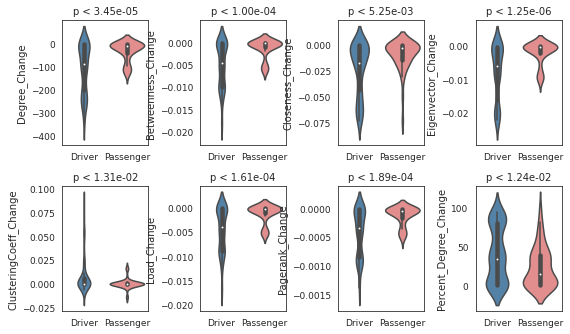

In [82]:
pal = ['steelblue','lightcoral']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(8,4.75))
# fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(6.5,3.86))

df = raw_df.copy()
for i, feat_arr in enumerate(res_feat_arr[2:]+[res_feat_arr[1]]):
    (a,p) = st.mannwhitneyu(df[df['Mut_type']=='Driver'][feat_arr],\
                            df[df['Mut_type']=='Passenger'][feat_arr])
    ax = plt.subplot(2, 4, i+1)
    ax = sns.violinplot(x='Mut_type', y=feat_arr, data=df, palette=pal)
    plt.title('p < %.2e' % p)
    plt.ylabel(feat_arr)
    plt.xlabel('')
    
fig.tight_layout()
fig.subplots_adjust(wspace=.6)
plt.savefig('../out/figures/Fig6.pdf', transparent=True, dpi=300)
plt.show()